# Case Study 3 - Privacy

## The Task
Make a private version of the Brazil COVID-19 dataset, that could safely be used by anyone to create a COVID-19 survival analysis model, without the risk of (re-)identification of individuals.

### Imports
Lets get the imports out of the way. We import the required standard and 3rd party libraries and relevant Synthcity modules. We can also set the level of logging here, using Synthcity's bespoke logger. 

In [4]:
# Standard
import sys
import warnings
from pathlib import Path

# 3rd party
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# synthcity
import synthcity.logger as log
from synthcity.utils import serialization
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import (GenericDataLoader, SurvivalAnalysisDataLoader)
from synthcity.metrics import Metrics

# Configure warnings and logging
warnings.filterwarnings("ignore")

# Set the level for the logging
# log.add(sink=sys.stderr, level="DEBUG")
log.remove()

### Load the data

Load the data from file into a SurvivalAnalysisDataLoader object. For this we need to pass the names of our `target_column` and our `time_to_event_column` to the data loader. Then we can see the data by calling loader.dataframe() and get the infomation about the data loader object with loader.info().

In [5]:
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised.csv")
loader = SurvivalAnalysisDataLoader(
    X,
    target_column="is_dead",
    time_to_event_column="Days_hospital_to_outcome",
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"],
    random_state=42,
)

display(loader.dataframe())
# display(loader.info())

,is_dead,Days_hospital_to_outcome,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
0,0,3,1,0,0,2,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,7,75,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,6,81,1,0,2,1,1,0,1,...,0,1,0,1,0,0,0,0,0,0
5,1,7,64,1,1,4,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
6,1,5,62,1,1,4,1,1,0,1,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,0,5,52,0,0,4,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
6878,0,2,34,1,1,4,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6879,0,18,44,1,1,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6880,0,17,23,1,1,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Synthetic generators

We can list the available generic synthetic generators by calling list() on the Plugins object.

In [6]:
print(Plugins(categories=["generic", "survival_analysis"]).list())

['privbayes', 'sdv_ctgan', 'bayesian_network', 'survival_ctgan', 'adsgan', 'survae', 'nflow', 'survival_gan', 'pategan', 'ctgan', 'dpgan', 'tvae', 'sdv_tvae', 'survival_nflow', 'rtvae']


### Create synthetic datasets

From the above list we are going to select the synthetic generation models for privacy: "privbayes", "dpgan", "adsgan", and "pategan". Then we will create and fit the synthetic model before using it to generate a synthetic dataset.

In [7]:
outdir = Path("saved_models")
prefix = "privacy"
n_iter = 100
models=[
    "dpgan",
    "adsgan",
    "pategan",
]
for model in models:
    save_file = outdir / f"{prefix}.{model}_numericalised_n_iter={n_iter}_4.bkp"
    if not Path(save_file).exists():
        print(model)
        syn_model = Plugins().get(model)
        syn_model.fit(loader)
        syn_model.generate(count=6882).dataframe()
        serialization.save_to_file(save_file, syn_model)

privbayes


 73%|███████▎  | 16/22 [14:48:59<22:42:56, 13629.50s/it]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


### Evaluate the generated synthetic dataset in terms of privacy

We can select some metrics to choose. The full list of available metrics can be seen by calling Metrics().list(). We are going to use the metrics associated with detection of the synthetic data and data privacy. Then we will print them to a dataframe to look at the results.

In [5]:
eval_results = {}
for model in models:
    print(model)
    save_file = outdir / f"{prefix}.{model}_numericalised_n_iter={n_iter}_4.bkp"
    if Path(save_file).exists():
        syn_model = serialization.load_from_file(save_file)
        selected_metrics = {
            "detection": ["detection_xgb", "detection_mlp", "detection_gmm"],
            "privacy": ["delta-presence", "k-anonymization", "k-map", "distinct l-diversity", "identifiability_score"],
            'performance': ['linear_model', 'mlp', 'xgb', 'feat_rank_distance'],
        }
        my_metrics = Metrics()
        selected_metrics_in_my_metrics = {k: my_metrics.list()[k] for k in my_metrics.list().keys() & selected_metrics.keys()}
        X_syn = syn_model.generate(count=6882)
        evaluation = my_metrics.evaluate(
            loader,
            X_syn,
            task_type="survival_analysis",
            metrics=selected_metrics_in_my_metrics,
            workspace="workspace",
        )
        display(evaluation)
        eval_results[model] = evaluation

dpgan


,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
performance.linear_model.gt.c_index,0.652484,0.652484,0.652484,0.0,0.652484,0.0,1,0,2.42,maximize
performance.linear_model.gt.brier_score,0.226254,0.226254,0.226254,0.0,0.226254,0.0,1,0,2.42,maximize
performance.linear_model.syn_id.c_index,0.500503,0.500503,0.500503,0.0,0.500503,0.0,1,0,2.42,maximize
performance.linear_model.syn_id.brier_score,0.164124,0.164124,0.164124,0.0,0.164124,0.0,1,0,2.42,maximize
performance.linear_model.syn_ood.c_index,0.496125,0.496125,0.496125,0.0,0.496125,0.0,1,0,2.42,maximize
performance.linear_model.syn_ood.brier_score,0.236532,0.236532,0.236532,0.0,0.236532,0.0,1,0,2.42,maximize
performance.mlp.gt.c_index,0.636670,0.636670,0.636670,0.0,0.636670,0.0,1,0,44.97,maximize
performance.mlp.gt.brier_score,0.116824,0.116824,0.116824,0.0,0.116824,0.0,1,0,44.97,maximize
performance.mlp.syn_id.c_index,0.467471,0.467471,0.467471,0.0,0.467471,0.0,1,0,44.97,maximize
performance.mlp.syn_id.brier_score,0.357924,0.357924,0.357924,0.0,0.357924,0.0,1,0,44.97,maximize


adsgan


,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
performance.linear_model.gt.c_index,6.524840e-01,6.524840e-01,6.524840e-01,0.0,6.524840e-01,0.0,1,0,5.99,maximize
performance.linear_model.gt.brier_score,2.262538e-01,2.262538e-01,2.262538e-01,0.0,2.262538e-01,0.0,1,0,5.99,maximize
performance.linear_model.syn_id.c_index,6.529799e-01,6.529799e-01,6.529799e-01,0.0,6.529799e-01,0.0,1,0,5.99,maximize
performance.linear_model.syn_id.brier_score,4.282745e-01,4.282745e-01,4.282745e-01,0.0,4.282745e-01,0.0,1,0,5.99,maximize
performance.linear_model.syn_ood.c_index,6.704779e-01,6.704779e-01,6.704779e-01,0.0,6.704779e-01,0.0,1,0,5.99,maximize
performance.linear_model.syn_ood.brier_score,4.146278e-01,4.146278e-01,4.146278e-01,0.0,4.146278e-01,0.0,1,0,5.99,maximize
performance.mlp.gt.c_index,6.366697e-01,6.366697e-01,6.366697e-01,0.0,6.366697e-01,0.0,1,0,33.68,maximize
performance.mlp.gt.brier_score,1.168239e-01,1.168239e-01,1.168239e-01,0.0,1.168239e-01,0.0,1,0,33.68,maximize
performance.mlp.syn_id.c_index,6.122037e-01,6.122037e-01,6.122037e-01,0.0,6.122037e-01,0.0,1,0,33.68,maximize
performance.mlp.syn_id.brier_score,1.182742e-01,1.182742e-01,1.182742e-01,0.0,1.182742e-01,0.0,1,0,33.68,maximize


pategan


,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
performance.linear_model.gt.c_index,0.652484,0.652484,0.652484,0.0,0.652484,0.0,1,0,2.73,maximize
performance.linear_model.gt.brier_score,0.226254,0.226254,0.226254,0.0,0.226254,0.0,1,0,2.73,maximize
performance.linear_model.syn_id.c_index,0.571691,0.571691,0.571691,0.0,0.571691,0.0,1,0,2.73,maximize
performance.linear_model.syn_id.brier_score,0.121945,0.121945,0.121945,0.0,0.121945,0.0,1,0,2.73,maximize
performance.linear_model.syn_ood.c_index,0.570163,0.570163,0.570163,0.0,0.570163,0.0,1,0,2.73,maximize
performance.linear_model.syn_ood.brier_score,0.178714,0.178714,0.178714,0.0,0.178714,0.0,1,0,2.73,maximize
performance.mlp.gt.c_index,0.636670,0.636670,0.636670,0.0,0.636670,0.0,1,0,20.91,maximize
performance.mlp.gt.brier_score,0.116824,0.116824,0.116824,0.0,0.116824,0.0,1,0,20.91,maximize
performance.mlp.syn_id.c_index,0.500024,0.500024,0.500024,0.0,0.500024,0.0,1,0,20.91,maximize
performance.mlp.syn_id.brier_score,0.122521,0.122521,0.122521,0.0,0.122521,0.0,1,0,20.91,maximize


The above table contains all the infomation we need to evaluate the methods, but lets convert it to a format where it is easier to compare the methods

In [6]:
means = []
for plugin in eval_results:
    data = eval_results[plugin]["mean"]
    directions = eval_results[plugin]["direction"].to_dict()
    means.append(data)

out = pd.concat(means, axis=1)
out.set_axis(eval_results.keys(), axis=1, inplace=True)

bad_highlight = "background-color: lightcoral;"
ok_highlight = "background-color: green;"
default = ""


def highlights(row):
    metric = row.name
    if directions[metric] == "minimize":
        best_val = np.min(row.values)
        worst_val = np.max(row)
    else:
        best_val = np.max(row.values)
        worst_val = np.min(row)

    styles = []
    for val in row.values:
        if val == best_val:
            styles.append(ok_highlight)
        elif val == worst_val:
            styles.append(bad_highlight)
        else:
            styles.append(default)

    return styles


out.style.apply(highlights, axis=1)

,dpgan,adsgan,pategan
performance.linear_model.gt.c_index,0.652484,0.652484,0.652484
performance.linear_model.gt.brier_score,0.226254,0.226254,0.226254
performance.linear_model.syn_id.c_index,0.500503,0.652980,0.571691
performance.linear_model.syn_id.brier_score,0.164124,0.428274,0.121945
performance.linear_model.syn_ood.c_index,0.496125,0.670478,0.570163
performance.linear_model.syn_ood.brier_score,0.236532,0.414628,0.178714
performance.mlp.gt.c_index,0.636670,0.636670,0.636670
performance.mlp.gt.brier_score,0.116824,0.116824,0.116824
performance.mlp.syn_id.c_index,0.467471,0.612204,0.500024
performance.mlp.syn_id.brier_score,0.357924,0.118274,0.122521


### Results of evaluation

We are using two types of metric here to dicsuss privacy: detection and privacy. Detection metrics measure the ability to identify the real data compared to the synthetic data. This has impacts on privacy as if an attacker can identify the real patients in a dataset they can then go about using the subset of real records to try and re-identify the real individuals, i.e. ability to identify the real records reduces the chance of a patient being lost in a crowd of similar synthetic records. The privacy metrics measure how easy it would be to re-identify a patient given the quasi-identifying fields in the dataset.
Generally, ADSGAN performs best in synthetic data detection tasks, then PATEGAN, and DPGAN tends to perform very poorly.

k-anonymization - risk of re-identification is approximately 1/k according to [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2528029/). Therefore the risk of re-identification is < 2% for DPGAN or ADSGAN and for PATEGAN it is < 3%. In any case there is huge improvement from ground truth k=3. For PATEGAN there is >11-fold increase in k.

k-map - is a metric where every combination of values for the quasi-identifiers appears at least k times in the synthetic dataset. ADSGAN performs worse than PATEGAN, but DPGAN comes out on top.

l-diversity - Is a similar metric to k-anonymization, but ir is also concerned with the diversity of the generalized block. We see the same pattern as for k-anonymization.

identifiability_score - Risk of re-identification as defined in [this paper](https://ieeexplore.ieee.org/document/9034117). This is the best for DPGAN. ADSGAN and PATEGAN perform worse.

### Conclusion
Generally, it seems DPGAN performs best in the privacy metrics, but the synthetic data is completely distinguishable from the real data by multiple detection algorithms, significantly reducing its utility. ADSGAN performs best in the detection metrics such that detection is not much better than random chance, with PATEGAN second best. ADSGAN and PATEGAN perform better in the detection metrics, but worse in privacy. These need balancing up to find the best solution for your use case.

## Synthetic Data Quality

To get a good sense of the quality of the synthetic datasets and validate our previous conclusion. Lets plot the correlation/strength-of-association of features in data-set with both categorical and continuous features using:
- Pearson's R for continuous-continuous cases
- Correlation Ratio for categorical-continuous cases
- Cramer's V or Theil's U for categorical-categorical cases

In each of the following plots we are looking for the synthetic data to be as similar to the real data as possible. That is minimal values for Jensen-Shannon distance and pairwise correlation distance, and T-SNEs with similar looking distribution in the representation space.

dpgan


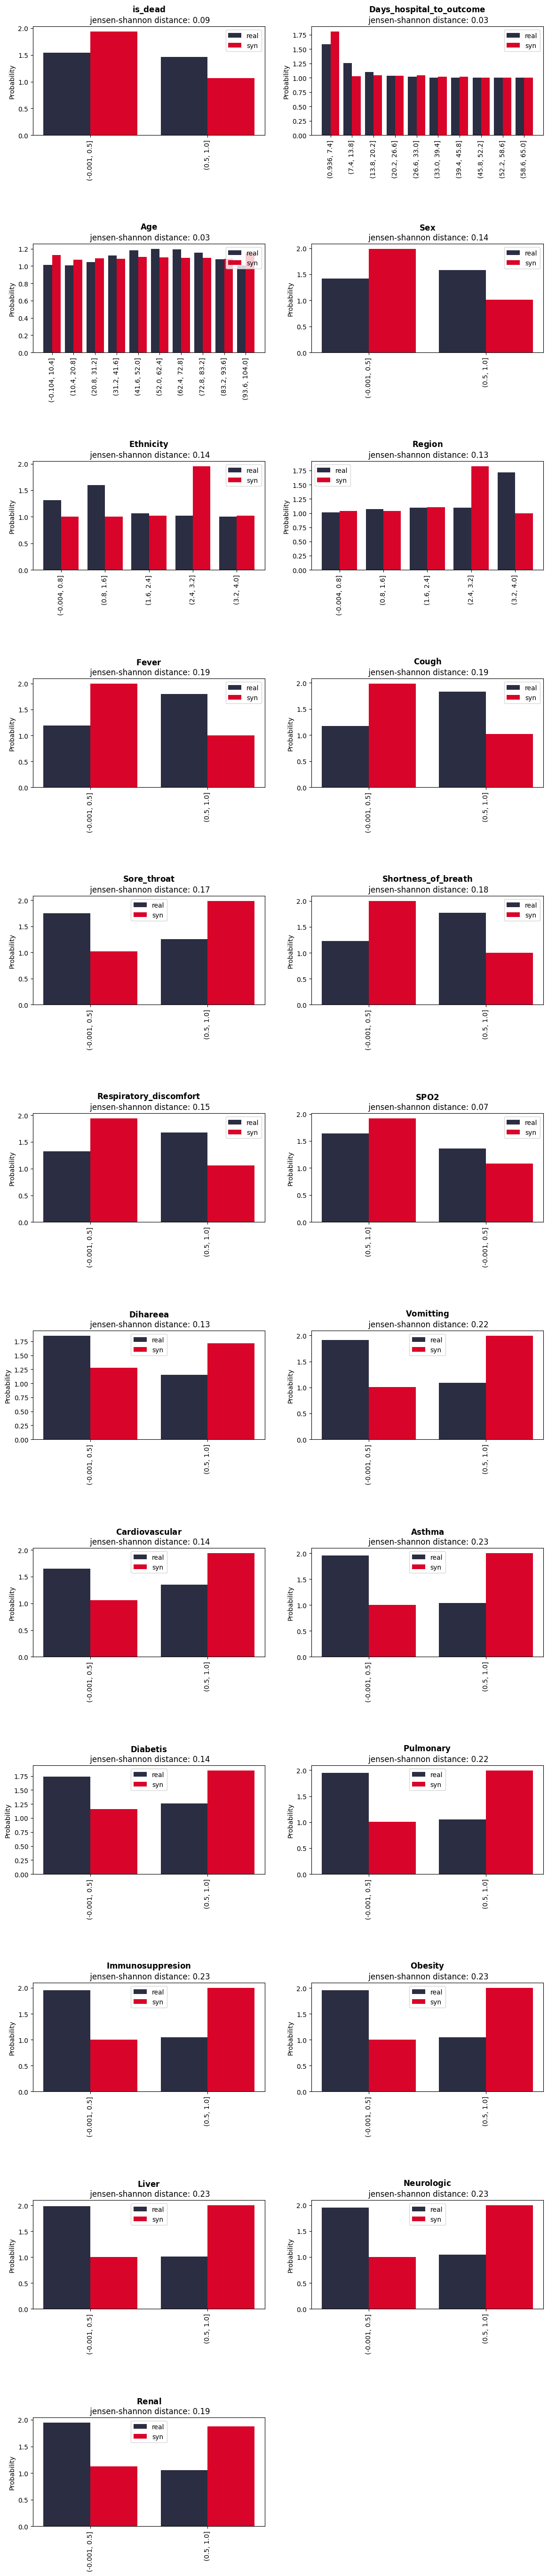

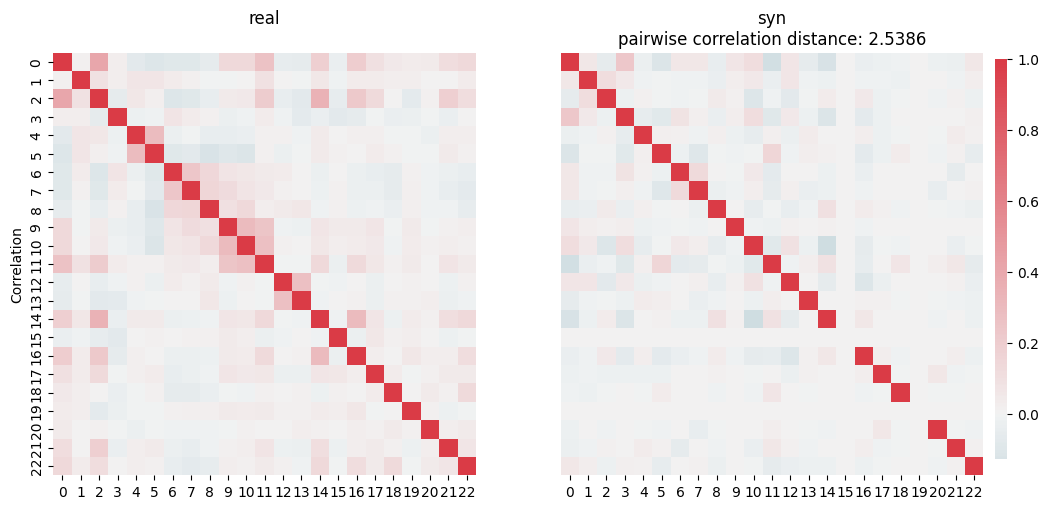

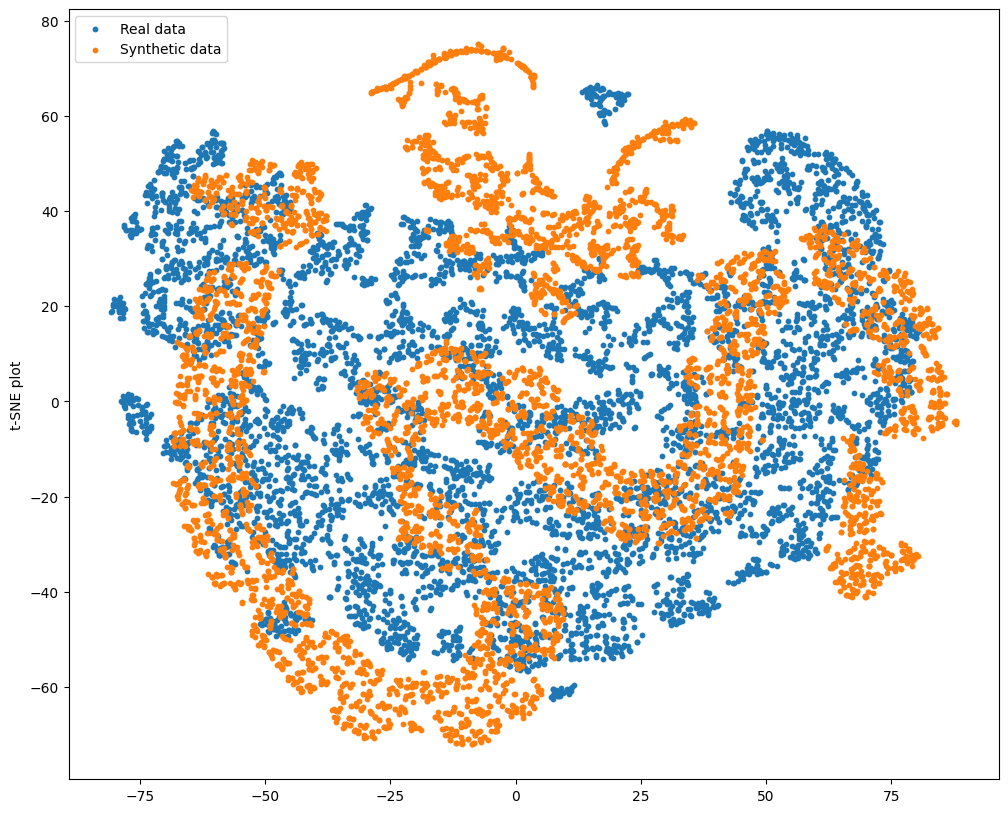

adsgan


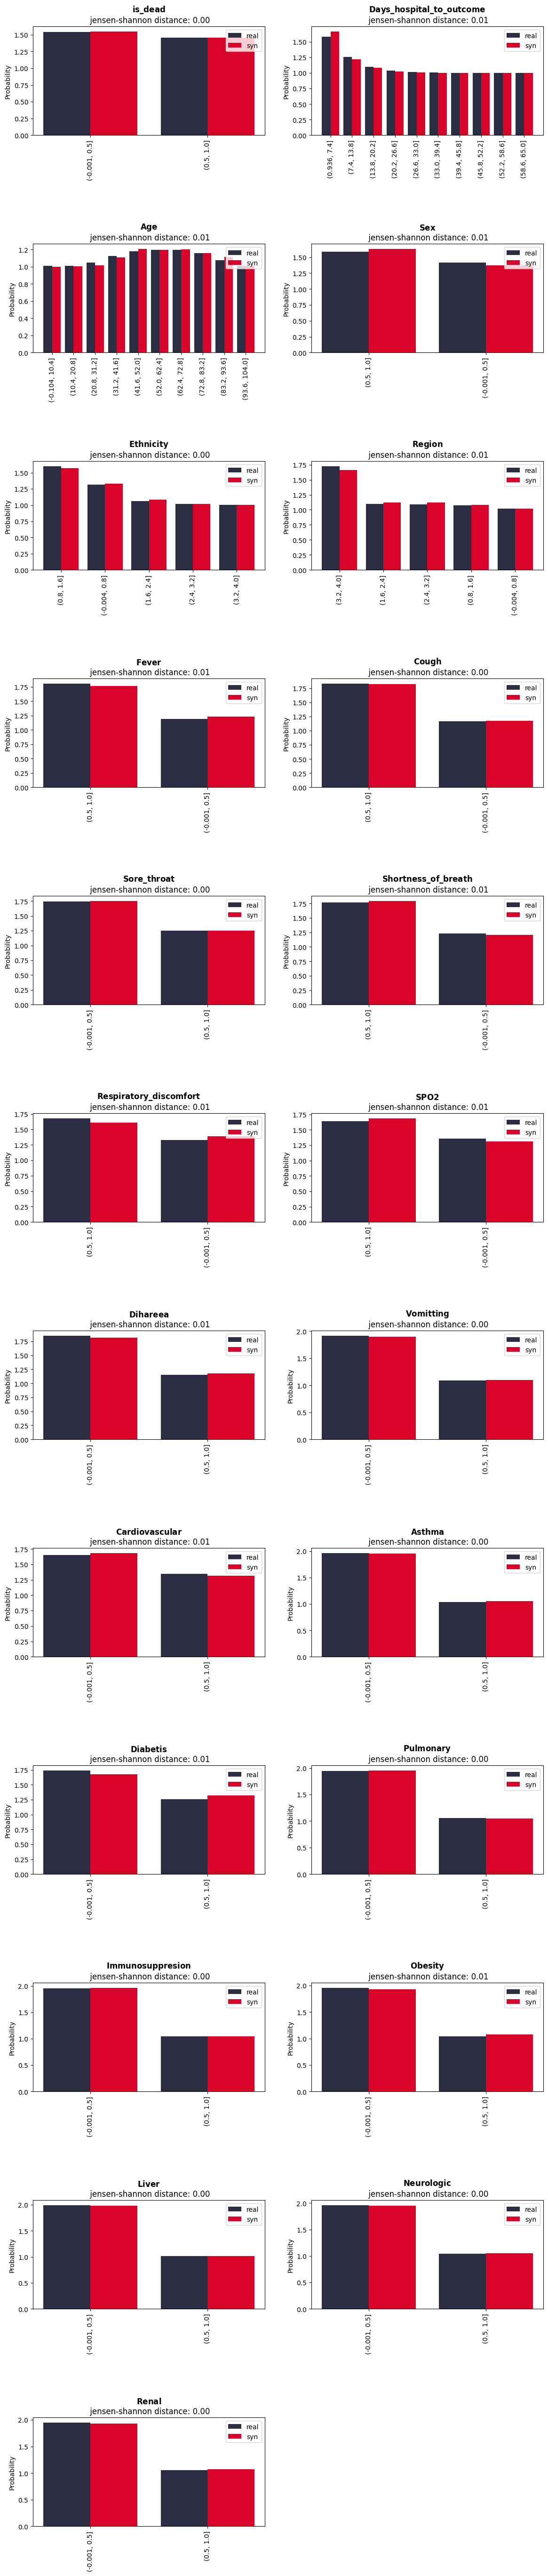

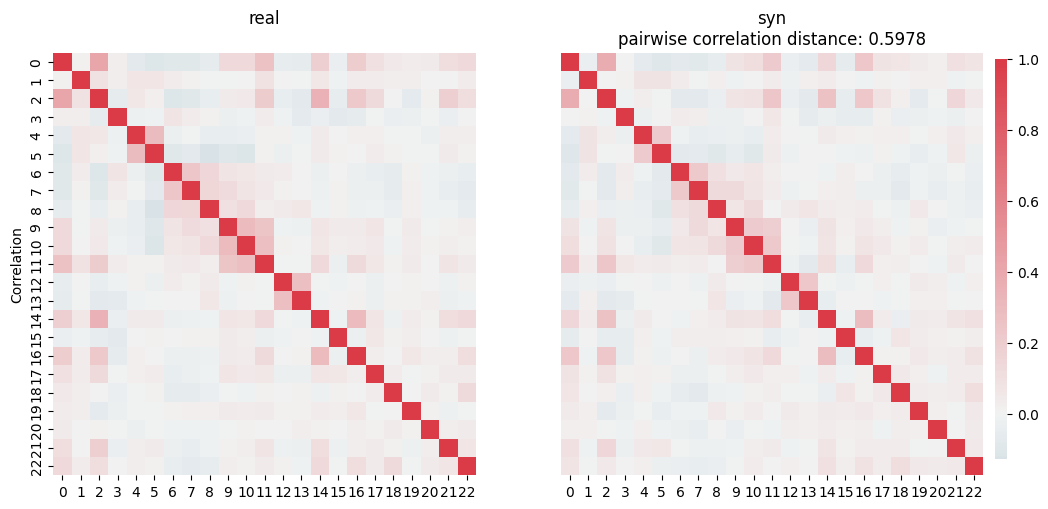

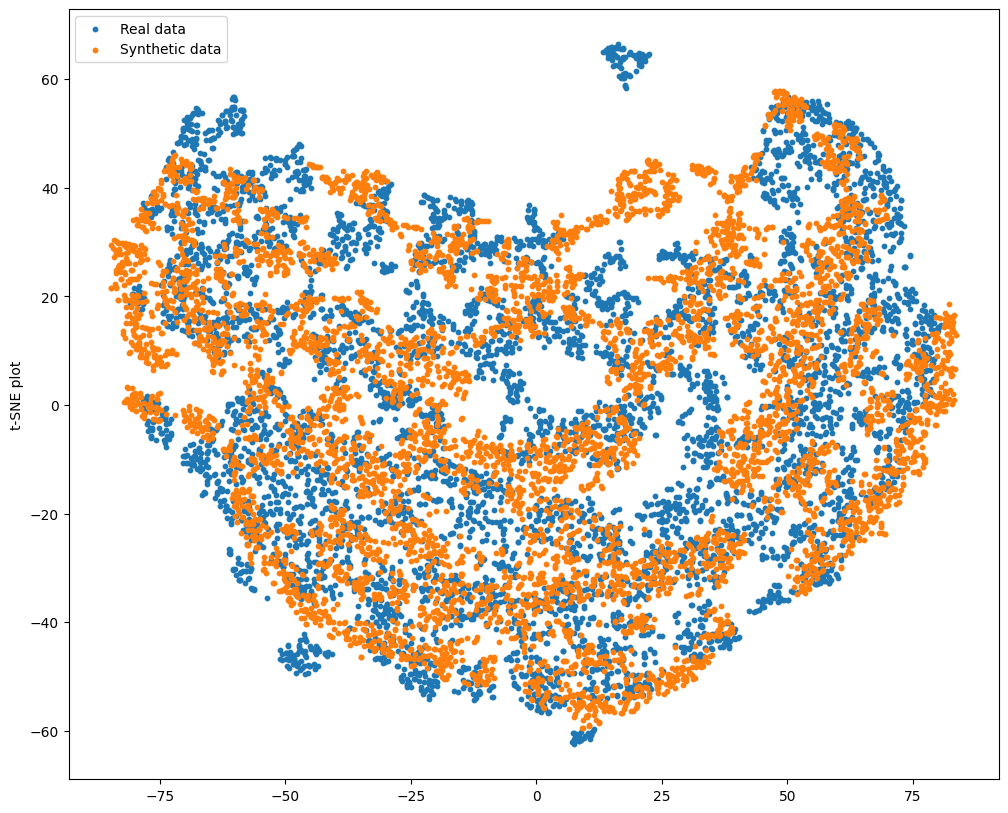

pategan


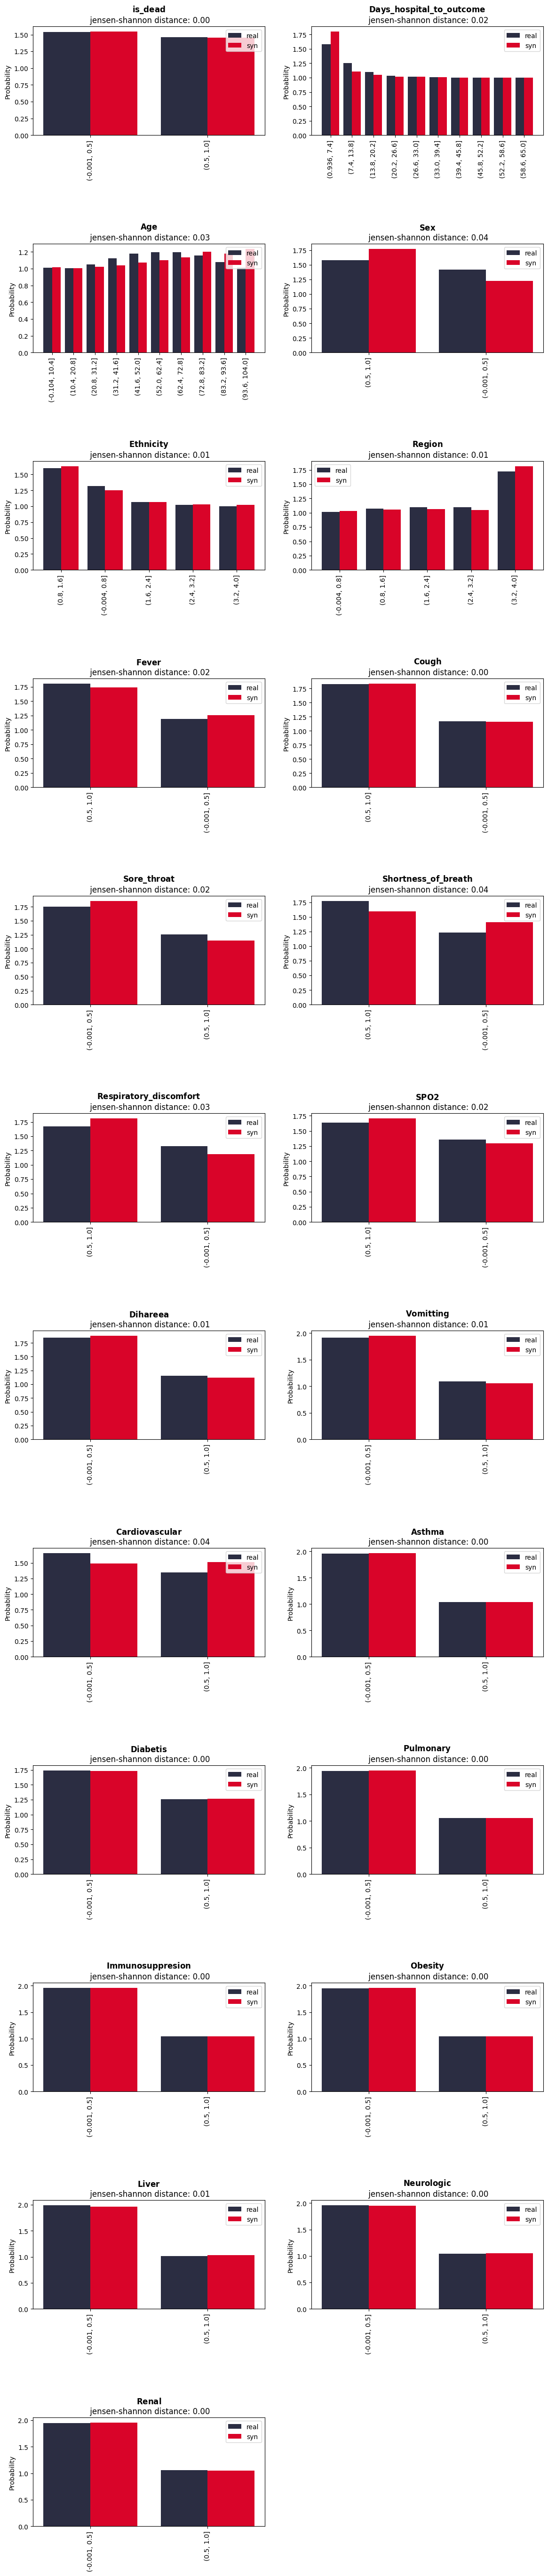

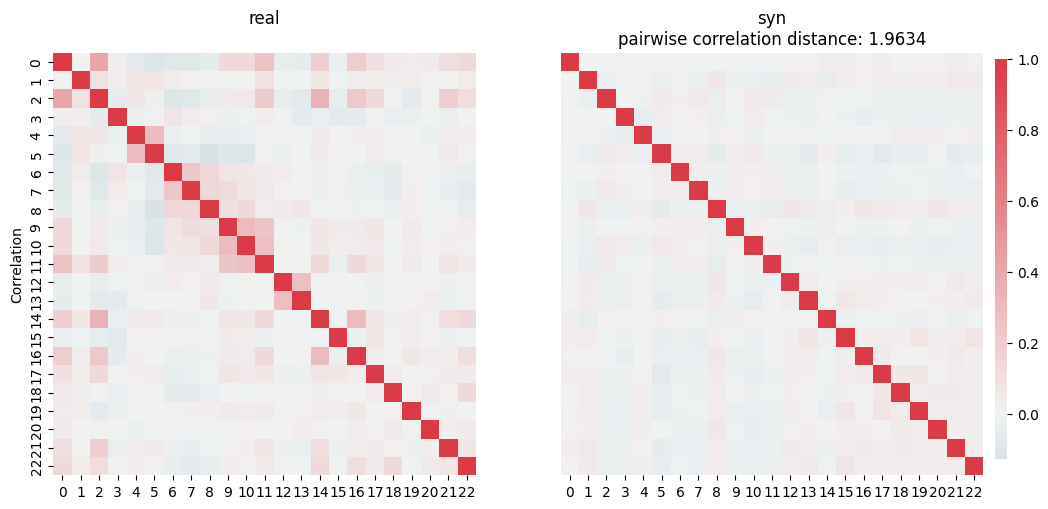

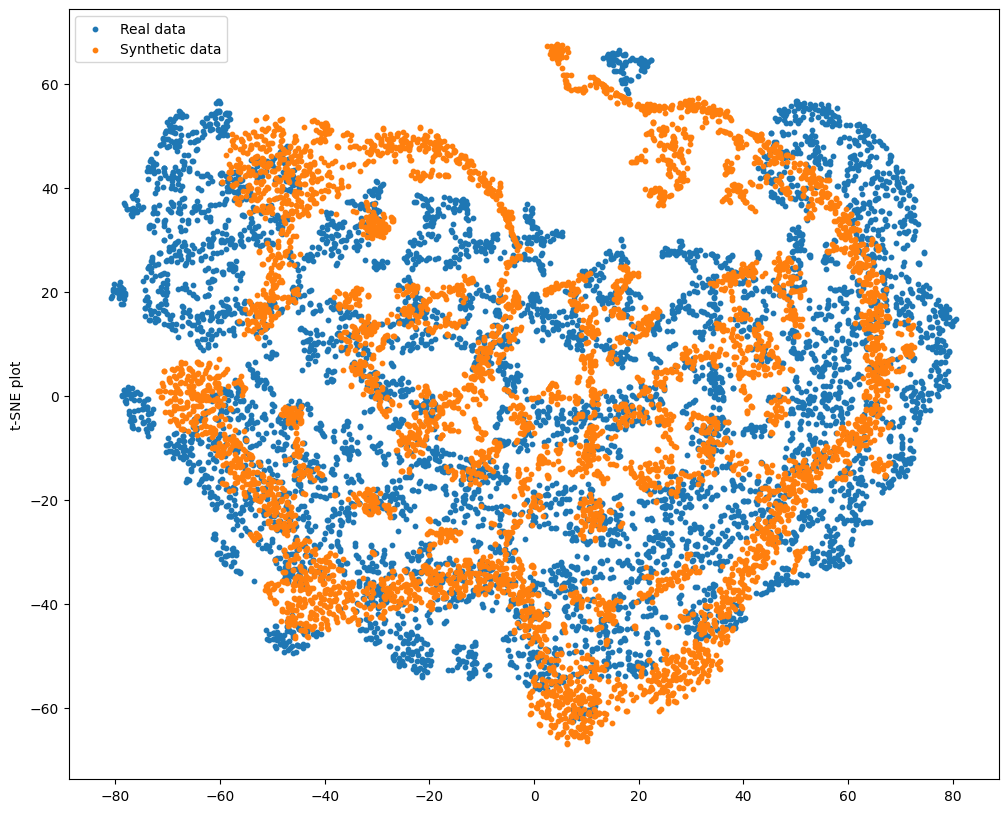

In [7]:
import matplotlib.pyplot as plt
for model in models:
    print(model)
    save_file = outdir / f"{prefix}.{model}_numericalised_4.bkp"
    if Path(save_file).exists():
        syn_model = serialization.load_from_file(save_file)
        syn_model.plot(plt, loader, plots=["associations","marginal", "tsne"])
        plt.show()

## Training models on both sets of data

Please now train your own model on both the original dataset and each of the private datasets we have generated to see if you reach the same conclusion. Which privacy method provides the best performance and what are the trade-offs?